In [1]:
from cat import random_literal_cat, random_literal_cloud, cat_shape
import matplotlib.pyplot as plt
import jax
import jax.random as random
import numpy as np
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from mean_flows import *
from dataclasses import dataclass
from tqdm import tqdm
from functools import partial
from typing import Optional, Tuple

### Check GPU Availabilility

In [2]:
# Check what devices JAX sees
devices = jax.devices()
print("JAX devices:")
for d in devices:
    print(" ", d)

# Check if GPU is available
if any(d.platform == "gpu" for d in devices):
    print("\n✅ GPU is available!")
else:
    print("\n❌ GPU is NOT available — JAX is running on CPU.")

# Run a small computation to confirm backend
x = jnp.ones((1000, 1000))
y = jnp.dot(x, x)
print(f"\nComputation result shape: {y.shape}")
print("Backend used:", jax.default_backend())

JAX devices:
  cuda:0

✅ GPU is available!

Computation result shape: (1000, 1000)
Backend used: gpu


### Target distribution

(2, 1000)


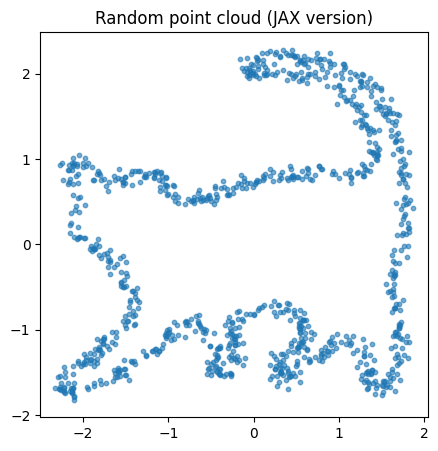

In [3]:
key = random.PRNGKey(0)
random_points = random_literal_cat(key, 1000)
print(random_points.shape)
x, y = random_points[0, :], random_points[1, :]
plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=10, alpha=0.6)
plt.axis("equal")
plt.title("Random point cloud (JAX version)")
plt.show()

### Model:

In [ ]:

# ----- data generator (your version) -----
def make_batch(key, batch_size):
    pts = random_literal_cat(key, batch_size)  # (2, B)
    return pts.T.astype(T)                     # (B, 2)



In [5]:
T = jnp.float32

class RandomFourierFeatures(nn.Module):
    in_dim: int
    emb_dim: int
    sigma: float = 1.0  # similar to 1f0 in Julia code

    @nn.compact
    def __call__(self, x):
        # x: (B, in_dim)
        W = self.param(
            "W",
            nn.initializers.normal(stddev=1.0 / self.sigma),
            (self.in_dim, self.emb_dim),
        )
        b = self.param(
            "b",
            nn.initializers.uniform(scale=2 * jnp.pi),
            (self.emb_dim,),
        )
        proj = x @ W + b  # (B, emb_dim)
        return jnp.sqrt(2.0 / self.emb_dim) * jnp.cos(proj)

class MeanFlowFModel(nn.Module):
    embeddim: int = 128
    spacedim: int = 2
    layers: int = 3  # number of residual layers

    @nn.compact
    def __call__(self, z, r, t):
        """
        z: (B, spacedim)  - current state
        r: (B,) or scalar - lower time
        t: (B,) or scalar - upper time
        returns: (B, spacedim) velocity u(z, r, t)
        """
        z = jnp.asarray(z)
        B = z.shape[0]

        # --- broadcast r, t to (B, 1) ---
        r = jnp.asarray(r)
        t = jnp.asarray(t)

        if r.ndim == 0:
            r_vec = jnp.full((B, 1), r, dtype=z.dtype)
        elif r.ndim == 1:
            r_vec = r[:, None]
        else:
            r_vec = r  # assume already (B, 1) or compatible

        if t.ndim == 0:
            t_vec = jnp.full((B, 1), t, dtype=z.dtype)
        elif t.ndim == 1:
            t_vec = t[:, None]
        else:
            t_vec = t

        # --- time embedding: use (t, r) or (t, t-r) – here we pick (t, r) ---
        tr = jnp.concatenate([t_vec, r_vec], axis=-1)  # (B, 2)
        time_feat = RandomFourierFeatures(in_dim=2, emb_dim=self.embeddim)(tr)
        time_feat = nn.swish(nn.Dense(self.embeddim)(time_feat))

        # --- state embedding: z in R^spacedim ---
        state_feat = RandomFourierFeatures(in_dim=self.spacedim, emb_dim=self.embeddim)(z)
        state_feat = nn.swish(nn.Dense(self.embeddim)(state_feat))

        # combine time + state embeddings
        x = time_feat + state_feat  # (B, embeddim)

        # --- residual stack: x = x + ff(x) ---
        for i in range(self.layers):
            h = nn.swish(nn.Dense(self.embeddim, name=f"ff_{i}")(x))
            x = x + h

        # --- decode to velocity u(z, r, t) ---
        u = nn.Dense(self.spacedim, name="decode")(x)  # (B, spacedim)
        return u


In [6]:
from flax.training import train_state
import optax

class MFTrainState(train_state.TrainState):
    pass

def init_meanflow(rng, embeddim=256, layers=3, spacedim=2):
    model = MeanFlowFModel(embeddim=embeddim, layers=layers, spacedim=spacedim)

    z0 = jnp.zeros((1, spacedim), dtype=T)
    r0 = jnp.array(0.0, dtype=T)
    t0 = jnp.array(1.0, dtype=T)

    params = model.init(rng, z0, r0, t0)["params"]
    tx = optax.adamw(2e-3)
    state = MFTrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state, model


#### Train step and sampling:

In [7]:
@partial(jax.jit, static_argnums=(3, 4, 5, 6))
def meanflow_train_step(state, key, x, ratio_of_sampling, distribution, sampler_args, p):
    def loss_fn(params):
        return algorithm_1(
            state.apply_fn,    
            params, 
            x,
            None,
            key,
            ratio_of_sampling,
            distribution,
            sampler_args,
            p,
            None
        )
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

def sample_minibatch(state, key, batch_size, dim=2):
    def fn_p(z, r, t):
        return state.apply_fn({"params": state.params}, z, r, t)
    return algorithm_2(fn_p, dim, key, batch_size, 200)  # (B,2)

In [8]:
def train_meanflow(num_steps, batch_size, embeddim, layers, seed, ratio_of_sampling, distribution, sampler_args, p):
    rng = random.PRNGKey(seed)
    rng, k_init = random.split(rng)
    state, _ = init_meanflow(k_init, embeddim=embeddim, layers=layers, spacedim=2)

    for step in tqdm(range(1, num_steps+1)):
        rng, k_data, k_step, k_log = random.split(rng, 4)
        x = make_batch(k_data, batch_size)  # (B,2), dtype T
        state = meanflow_train_step(state, k_step, x, ratio_of_sampling, distribution, sampler_args, p)
        loss = algorithm_1(state.apply_fn, state.params, x, None, k_log, ratio_of_sampling, distribution, sampler_args, p, None)
        if step % 50 == 0:
            print(f"[step {step:4d}] loss={float(loss):.6f}")

    return rng, state

ratio_of_sampling = 0.25
distribution = "lognorm"
sampler_args = (-0.4, 1.0)
p = 1.0
def demo_train_and_sample():
    rng, state = train_meanflow(4000, 2048, 256, 5, 0, ratio_of_sampling, distribution, sampler_args, p)

    rng, k_samp, k_real = random.split(rng, 3)
    gen = sample_minibatch(state, k_samp, batch_size=2048, dim=2)  # (2048,2)
    real = make_batch(k_real, 2048)

    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(5,5))
        plt.scatter(real[:,0], real[:,1], s=6, alpha=0.4, label="real")
        plt.scatter(gen[:,0],  gen[:,1],  s=6, alpha=0.4, label="gen")
        plt.axis("equal"); plt.legend(); plt.title("Mean Flow training (data space)")
        plt.show()
    except Exception as e:
        print("Plot skipped:", e)
    return state

  1%|▊                                                                    | 50/4000 [00:21<17:42,  3.72it/s]

[step   50] loss=0.997063


  2%|█▋                                                                  | 100/4000 [00:37<31:57,  2.03it/s]

[step  100] loss=0.997127


  4%|██▌                                                                 | 150/4000 [00:55<21:15,  3.02it/s]

[step  150] loss=0.997425


  5%|███▍                                                                | 200/4000 [01:09<17:27,  3.63it/s]

[step  200] loss=0.997040


  6%|████▎                                                               | 250/4000 [01:26<24:56,  2.51it/s]

[step  250] loss=0.997915


  8%|█████                                                               | 300/4000 [01:42<16:14,  3.80it/s]

[step  300] loss=0.997831


  9%|█████▉                                                              | 350/4000 [02:00<16:07,  3.77it/s]

[step  350] loss=0.997672


 10%|██████▊                                                             | 400/4000 [02:15<21:04,  2.85it/s]

[step  400] loss=0.997182


 11%|███████▋                                                            | 450/4000 [02:33<17:58,  3.29it/s]

[step  450] loss=0.996827


 12%|████████▌                                                           | 500/4000 [02:48<17:17,  3.37it/s]

[step  500] loss=0.997392


 14%|█████████▎                                                          | 550/4000 [03:04<19:08,  3.00it/s]

[step  550] loss=0.997645


 15%|██████████▏                                                         | 600/4000 [03:17<14:02,  4.04it/s]

[step  600] loss=0.996839


 16%|███████████                                                         | 650/4000 [03:34<40:32,  1.38it/s]

[step  650] loss=0.996486


 18%|███████████▉                                                        | 700/4000 [03:50<13:15,  4.15it/s]

[step  700] loss=0.997362


 19%|████████████▊                                                       | 750/4000 [04:04<15:12,  3.56it/s]

[step  750] loss=0.997089


 20%|█████████████▌                                                      | 800/4000 [04:24<20:15,  2.63it/s]

[step  800] loss=0.996997


 21%|██████████████▍                                                     | 850/4000 [04:42<17:25,  3.01it/s]

[step  850] loss=0.997021


 22%|███████████████▎                                                    | 900/4000 [05:00<17:13,  3.00it/s]

[step  900] loss=0.997027


 24%|████████████████▏                                                   | 950/4000 [05:19<21:40,  2.35it/s]

[step  950] loss=0.997131


 25%|████████████████▊                                                  | 1000/4000 [05:36<12:38,  3.96it/s]

[step 1000] loss=0.996828


 26%|█████████████████▌                                                 | 1050/4000 [05:53<17:06,  2.87it/s]

[step 1050] loss=0.997113


 28%|██████████████████▍                                                | 1100/4000 [06:11<13:40,  3.53it/s]

[step 1100] loss=0.996317


 29%|███████████████████▎                                               | 1150/4000 [06:29<13:32,  3.51it/s]

[step 1150] loss=0.996537


 30%|████████████████████                                               | 1200/4000 [06:45<15:03,  3.10it/s]

[step 1200] loss=0.996344


 31%|████████████████████▉                                              | 1250/4000 [07:03<18:31,  2.47it/s]

[step 1250] loss=0.996233


 32%|█████████████████████▊                                             | 1300/4000 [07:28<31:54,  1.41it/s]

[step 1300] loss=0.997138


 34%|██████████████████████▌                                            | 1350/4000 [07:46<11:17,  3.91it/s]

[step 1350] loss=0.996942


 35%|███████████████████████▍                                           | 1400/4000 [08:06<24:09,  1.79it/s]

[step 1400] loss=0.995114


 36%|████████████████████████▎                                          | 1450/4000 [08:28<15:24,  2.76it/s]

[step 1450] loss=0.995809


 38%|█████████████████████████▏                                         | 1500/4000 [08:49<23:28,  1.77it/s]

[step 1500] loss=0.996832


 39%|█████████████████████████▉                                         | 1550/4000 [09:10<28:50,  1.42it/s]

[step 1550] loss=0.996697


 40%|██████████████████████████▊                                        | 1600/4000 [09:29<13:10,  3.03it/s]

[step 1600] loss=0.997351


 41%|███████████████████████████▋                                       | 1650/4000 [09:51<26:34,  1.47it/s]

[step 1650] loss=0.995402


 42%|████████████████████████████▍                                      | 1700/4000 [10:11<20:05,  1.91it/s]

[step 1700] loss=0.996131


 44%|█████████████████████████████▎                                     | 1750/4000 [10:30<10:35,  3.54it/s]

[step 1750] loss=0.996804


 45%|██████████████████████████████▏                                    | 1800/4000 [10:44<11:35,  3.17it/s]

[step 1800] loss=0.996287


 46%|██████████████████████████████▉                                    | 1850/4000 [11:00<09:13,  3.89it/s]

[step 1850] loss=0.997039


 48%|███████████████████████████████▊                                   | 1900/4000 [11:13<08:12,  4.27it/s]

[step 1900] loss=0.995941


 49%|████████████████████████████████▋                                  | 1950/4000 [11:31<17:56,  1.90it/s]

[step 1950] loss=0.995671


 50%|█████████████████████████████████▌                                 | 2000/4000 [11:45<09:32,  3.49it/s]

[step 2000] loss=0.997016


 51%|██████████████████████████████████▎                                | 2050/4000 [12:05<11:22,  2.86it/s]

[step 2050] loss=0.994915


 52%|███████████████████████████████████▏                               | 2100/4000 [12:20<08:19,  3.80it/s]

[step 2100] loss=0.996361


 54%|████████████████████████████████████                               | 2150/4000 [12:36<08:46,  3.51it/s]

[step 2150] loss=0.996424


 55%|████████████████████████████████████▊                              | 2200/4000 [12:51<08:31,  3.52it/s]

[step 2200] loss=0.997542


 56%|█████████████████████████████████████▋                             | 2250/4000 [13:07<09:34,  3.05it/s]

[step 2250] loss=0.995898


 57%|██████████████████████████████████████▌                            | 2300/4000 [13:20<08:21,  3.39it/s]

[step 2300] loss=0.996598


 59%|███████████████████████████████████████▎                           | 2350/4000 [13:34<08:02,  3.42it/s]

[step 2350] loss=0.995829


 60%|████████████████████████████████████████▏                          | 2400/4000 [13:51<07:55,  3.37it/s]

[step 2400] loss=0.995554


 61%|█████████████████████████████████████████                          | 2450/4000 [14:06<06:54,  3.74it/s]

[step 2450] loss=0.996412


 62%|█████████████████████████████████████████▉                         | 2500/4000 [14:25<06:33,  3.81it/s]

[step 2500] loss=0.996929


 64%|██████████████████████████████████████████▋                        | 2550/4000 [14:42<11:27,  2.11it/s]

[step 2550] loss=0.995450


 65%|███████████████████████████████████████████▌                       | 2600/4000 [15:00<07:54,  2.95it/s]

[step 2600] loss=0.997032


 66%|████████████████████████████████████████████▍                      | 2650/4000 [15:21<18:15,  1.23it/s]

[step 2650] loss=0.995791


 68%|█████████████████████████████████████████████▏                     | 2700/4000 [15:38<07:21,  2.94it/s]

[step 2700] loss=0.995517


 69%|██████████████████████████████████████████████                     | 2750/4000 [15:55<12:12,  1.71it/s]

[step 2750] loss=0.996407


 70%|██████████████████████████████████████████████▉                    | 2800/4000 [16:11<05:19,  3.75it/s]

[step 2800] loss=0.995668


 71%|███████████████████████████████████████████████▋                   | 2850/4000 [16:25<06:14,  3.07it/s]

[step 2850] loss=0.996131


 72%|████████████████████████████████████████████████▌                  | 2900/4000 [16:41<05:22,  3.41it/s]

[step 2900] loss=0.996362


 74%|█████████████████████████████████████████████████▍                 | 2950/4000 [17:03<12:47,  1.37it/s]

[step 2950] loss=0.996809


 75%|██████████████████████████████████████████████████▎                | 3000/4000 [17:19<05:17,  3.15it/s]

[step 3000] loss=0.996807


 76%|███████████████████████████████████████████████████                | 3050/4000 [17:34<04:11,  3.78it/s]

[step 3050] loss=0.995637


 78%|███████████████████████████████████████████████████▉               | 3100/4000 [17:51<05:38,  2.66it/s]

[step 3100] loss=0.995628


 79%|████████████████████████████████████████████████████▊              | 3150/4000 [18:07<06:31,  2.17it/s]

[step 3150] loss=0.996326


 80%|█████████████████████████████████████████████████████▌             | 3200/4000 [18:26<03:50,  3.47it/s]

[step 3200] loss=0.995658


 81%|██████████████████████████████████████████████████████▍            | 3250/4000 [18:50<05:32,  2.25it/s]

[step 3250] loss=0.994983


 82%|███████████████████████████████████████████████████████▎           | 3300/4000 [19:06<05:25,  2.15it/s]

[step 3300] loss=0.995229


 84%|████████████████████████████████████████████████████████           | 3350/4000 [19:30<04:14,  2.55it/s]

[step 3350] loss=0.996142


 85%|████████████████████████████████████████████████████████▉          | 3400/4000 [19:55<03:22,  2.97it/s]

[step 3400] loss=0.996362


 86%|█████████████████████████████████████████████████████████▊         | 3450/4000 [20:14<04:59,  1.84it/s]

[step 3450] loss=0.995320


 88%|██████████████████████████████████████████████████████████▋        | 3500/4000 [20:33<02:13,  3.73it/s]

[step 3500] loss=0.996246


 89%|███████████████████████████████████████████████████████████▍       | 3550/4000 [20:54<02:56,  2.55it/s]

[step 3550] loss=0.996522


 90%|████████████████████████████████████████████████████████████▎      | 3600/4000 [21:13<02:28,  2.69it/s]

[step 3600] loss=0.996215


 91%|█████████████████████████████████████████████████████████████▏     | 3650/4000 [21:33<04:41,  1.24it/s]

[step 3650] loss=0.995330


 92%|█████████████████████████████████████████████████████████████▉     | 3700/4000 [21:53<01:45,  2.84it/s]

[step 3700] loss=0.996410


 94%|██████████████████████████████████████████████████████████████▊    | 3750/4000 [22:16<02:57,  1.41it/s]

[step 3750] loss=0.996255


 95%|███████████████████████████████████████████████████████████████▋   | 3800/4000 [22:34<01:51,  1.79it/s]

[step 3800] loss=0.995672


 96%|████████████████████████████████████████████████████████████████▍  | 3850/4000 [22:52<00:47,  3.17it/s]

[step 3850] loss=0.996228


 98%|█████████████████████████████████████████████████████████████████▎ | 3900/4000 [23:08<00:36,  2.74it/s]

[step 3900] loss=0.996956


 99%|██████████████████████████████████████████████████████████████████▏| 3950/4000 [23:31<00:28,  1.76it/s]

[step 3950] loss=0.995638


100%|███████████████████████████████████████████████████████████████████| 4000/4000 [23:52<00:00,  2.79it/s]

[step 4000] loss=0.996471


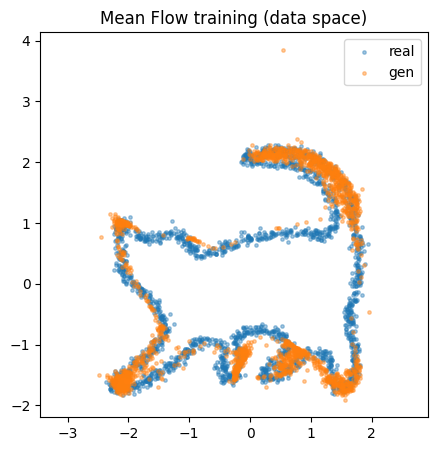

In [9]:
state = demo_train_and_sample()

### Labeled problem:

In [3]:

T = jnp.float32

# your cat_shape(t) is assumed defined as before

def make_batch(key, batch_size, sigma=T(0.05)):
    """
    Return a batch of points and integer class labels.

    cls = 1 -> cat
    cls = 2 -> circle

    x   : (B, 2)
    cls : (B,)
    """
    key_cls, key_ang, key_noise = random.split(key, 3)

    # sample classes {1,2}
    cls = random.randint(key_cls, (batch_size,), 1, 3, dtype=jnp.int32)  # 1=cat, 2=circle

    # sample angles
    angles = random.uniform(
        key_ang, (batch_size,), minval=0.0, maxval=2 * jnp.pi
    )  # (B,)

    # cat base points (B,2)
    cat_base = jax.vmap(lambda th: cat_shape(th) / 200.0)(angles)

    # circle base points (B,2)
    circle_base = jnp.stack([jnp.cos(angles), jnp.sin(angles)], axis=-1)

    # select cat or circle per sample based on cls
    is_cat = (cls == 1)[:, None]  # (B,1) bool
    base = jnp.where(is_cat, cat_base, circle_base)  # (B,2)

    # add noise
    noise = random.normal(key_noise, (batch_size, 2), dtype=T) * sigma
    x = (base + noise).astype(T)

    return x, cls


In [4]:

T = jnp.float32

class RandomFourierFeatures(nn.Module):
    in_dim: int
    emb_dim: int
    sigma: float = 1.0  # similar to 1f0 in Julia code

    @nn.compact
    def __call__(self, x):
        # x: (B, in_dim)
        W = self.param(
            "W",
            nn.initializers.normal(stddev=1.0 / self.sigma),
            (self.in_dim, self.emb_dim),
        )
        b = self.param(
            "b",
            nn.initializers.uniform(scale=2 * jnp.pi),
            (self.emb_dim,),
        )
        proj = x @ W + b  # (B, emb_dim)
        return jnp.sqrt(2.0 / self.emb_dim) * jnp.cos(proj)


class MeanFlowFModelCond(nn.Module):
    """
    MeanFlow velocity model with class conditioning.

    Convention:
      c = 0   -> unconditional
      c >= 1  -> real classes (1=cat, 2=circle, ...)
    """
    embeddim: int = 128
    spacedim: int = 2
    layers: int = 3      # number of residual layers
    num_classes: int = 3 # must be >= max(c) + 1

    @nn.compact
    def __call__(self, z, r, t, c):
        """
        z   : (B, spacedim)
        r,t : scalar or (B,)
        c : scalar int or (B,) int
              0 = unconditional, 1..num_classes-1 = real classes
        returns: (B, spacedim) velocity u(z, r, t | c)
        """
        z = jnp.asarray(z)
        B = z.shape[0]

        # --- broadcast r, t to (B, 1) ---
        r = jnp.asarray(r)
        t = jnp.asarray(t)

        if r.ndim == 0:
            r_vec = jnp.full((B, 1), r, dtype=z.dtype)
        elif r.ndim == 1:
            r_vec = r[:, None]
        else:
            r_vec = r  # assume already (B, 1) or compatible

        if t.ndim == 0:
            t_vec = jnp.full((B, 1), t, dtype=z.dtype)
        elif t.ndim == 1:
            t_vec = t[:, None]
        else:
            t_vec = t

        # --- class labels: 0 = unconditional, >=1 = classes ---
        c = jnp.asarray(c)
        if c.ndim == 0:
            c = jnp.full((B,), c, dtype=jnp.int32)
        # now c: (B,), values in {0..num_classes-1}

        c_oh = jax.nn.one_hot(c, self.num_classes)  # (B, num_classes)
        cond_feat = nn.swish(nn.Dense(self.embeddim)(c_oh))  # (B, embeddim)

        # --- time embedding: (t, r) or (t, t-r); here (t, r) ---
        tr = jnp.concatenate([t_vec, r_vec], axis=-1)  # (B, 2)
        time_feat = RandomFourierFeatures(in_dim=2, emb_dim=self.embeddim)(tr)
        time_feat = nn.swish(nn.Dense(self.embeddim)(time_feat))

        # --- state embedding: z in R^spacedim ---
        state_feat = RandomFourierFeatures(in_dim=self.spacedim, emb_dim=self.embeddim)(z)
        state_feat = nn.swish(nn.Dense(self.embeddim)(state_feat))

        # combine time + state + class embeddings
        x = time_feat + state_feat + cond_feat  # (B, embeddim)

        # --- residual stack: x = x + ff(x) ---
        for i in range(self.layers):
            h = nn.swish(nn.Dense(self.embeddim, name=f"ff_{i}")(x))
            x = x + h

        # --- decode to velocity u(z, r, t | c) ---
        u = nn.Dense(self.spacedim, name="decode")(x)  # (B, spacedim)
        return u


In [5]:


class MFTrainState(train_state.TrainState):
    pass

def init_meanflow(rng, embeddim=256, layers=5, spacedim=2, num_classes=3):
    """
    Initialize MeanFlowFModelCond:
      cls = 0 -> unconditional
      cls = 1 -> cat
      cls = 2 -> circle
    """
    model = MeanFlowFModelCond(
        embeddim=embeddim,
        spacedim=spacedim,
        layers=layers,
        num_classes=num_classes,
    )

    z0   = jnp.zeros((1, spacedim), dtype=T)
    r0   = jnp.array(0.0, dtype=T)
    t0   = jnp.array(1.0, dtype=T)
    cls0 = jnp.array([0], dtype=jnp.int32)   # unconditional for init

    variables = model.init(rng, z0, r0, t0, cls0)
    params = variables["params"]

    tx = optax.adamw(2e-3)
    state = MFTrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state, model



### Train step and sampling:

In [6]:
@partial(jax.jit, static_argnums=(4, 5, 6, 7, 8))
def meanflow_train_step(state, key, x, c, ratio_of_sampling, distribution, sampler_args, p, omega):
    """
    state.apply_fn: (vars, z, r, t, c) -> u
    x   : (B, 2)
    c : (B,) int, 1=cat, 2=circle (0 will be created inside algorithm_1 for unconditional)
    """

    def loss_fn(params):
        return algorithm_1(
            state.apply_fn,     # fn
            params,             # params
            x,                  # x: (B,2)
            c,                # c: class labels (B,)
            key,
            ratio_of_sampling,
            distribution,
            sampler_args,
            p,
            omega,               # omega (no CFG yet)
        )

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

def sample_minibatch(state, key, batch_size, dim=2, cls_val=None, n_steps=200):
    """
    Sample from the trained mean flow model.

    Args:
      state    : MFTrainState with MeanFlowFModelCond (z,r,t,cls)
      key      : PRNGKey
      batch_size : int
      dim      : data dimension (2)
      cls_val  : None or int
                 - None -> unconditional / marginal sampling
                 - 1    -> cat
                 - 2    -> circle
      n_steps  : number of Euler steps in Algorithm 2

    Returns:
      x: (B, dim)
    """

    if cls_val is None:
        # unconditional / marginal sampling
        # choose cls=0 meaning "unconditional" for the whole batch
        # or, if your model treats cls=None as unconditional, you can ignore this
        def fn_p(z, r, t):
            # model ignores cls or treats cls=0 internally
            return state.apply_fn({"params": state.params}, z, r, t)
        return algorithm_2(fn_p, dim, key, batch_size, n_steps=n_steps, c=None)

    else:
        # conditional sampling for a fixed class
        cls = jnp.full((batch_size,), cls_val, dtype=jnp.int32)  # (B,)

        def fn_p(z, r, t, c_batch):
            # c_batch is (B,) integer labels
            return state.apply_fn({"params": state.params}, z, r, t, c_batch)

        return algorithm_2(fn_p, dim, key, batch_size, n_steps=n_steps, c=cls)



In [7]:
def train_meanflow(num_steps, batch_size, embeddim, layers, seed,
                   ratio_of_sampling, distribution, sampler_args, p, omega):
    rng = random.PRNGKey(seed)
    rng, k_init = random.split(rng)

    # init_meanflow should create MeanFlowFModelCond with num_classes >= 3
    state, _ = init_meanflow(k_init, embeddim=embeddim, layers=layers, spacedim=2)

    for step in tqdm(range(1, num_steps + 1)):
        rng, k_data, k_step, k_log = random.split(rng, 4)

        # NEW: make_batch returns (x, c)
        x, c = make_batch(k_data, batch_size)  # x: (B,2), c: (B,)

        # training step
        state = meanflow_train_step(
            state, k_step, x, c,
            ratio_of_sampling, distribution, sampler_args, p, omega
        )

        # quick loss log (non-jitted, fine for logging)
        loss = algorithm_1(
            state.apply_fn,
            state.params,
            x,
            c,         # pass classes here too
            k_log,
            ratio_of_sampling,
            distribution,
            sampler_args,
            p,
            omega
        )

        if step % 400 == 0:
            print(f"[step {step:4d}] loss={float(loss):.6f}")

    return rng, state


In [16]:
ratio_of_sampling = 0.25
distribution = "lognorm"
sampler_args = (-0.4, 1.0)
p = 1.0
omega = 3.0

def demo_train_and_sample():
    rng, state = train_meanflow(
        num_steps=4000,
        batch_size=2048,
        embeddim=256,
        layers=5,
        seed=0,
        ratio_of_sampling=ratio_of_sampling,
        distribution=distribution,
        sampler_args=sampler_args,
        p=p,
        omega=omega,
    )

    # split keys for sampling and real data
    rng, k_samp_marg, k_samp_cat, k_samp_circ, k_real = random.split(rng, 5)

    # generated samples
    gen_marg = sample_minibatch(
        state, k_samp_marg, batch_size=2048, dim=2, cls_val=0
    )  # (2048,2) marginal / unconditional

    gen_cat = sample_minibatch(
        state, k_samp_cat, batch_size=2048, dim=2, cls_val=1
    )  # class 1 (cat)

    gen_circ = sample_minibatch(
        state, k_samp_circ, batch_size=2048, dim=2, cls_val=2
    )  # class 2 (circle)

    # real data + labels
    real, real_cls = make_batch(k_real, 2048)  # real: (2048,2), real_cls: (2048,)

    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(2, 2, figsize=(10, 10))

        # 1) Real data, colored by class
        ax = axes[0, 0]
        ax.scatter(
            real[real_cls == 1, 0],
            real[real_cls == 1, 1],
            s=6,
            alpha=0.4,
            label="real cat (cls=1)",
        )
        ax.scatter(
            real[real_cls == 2, 0],
            real[real_cls == 2, 1],
            s=6,
            alpha=0.4,
            label="real circle (cls=2)",
        )
        ax.set_title("Real data")
        ax.set_aspect("equal", "box")
        ax.legend()

        # 2) Marginal (unconditional) generation
        ax = axes[0, 1]
        ax.scatter(gen_marg[:, 0], gen_marg[:, 1], s=6, alpha=0.4, label="gen marginal")
        ax.set_title("Generated (marginal / unconditional)")
        ax.set_aspect("equal", "box")
        ax.legend()

        # 3) Class-1 (cat) generation
        ax = axes[1, 0]
        ax.scatter(gen_cat[:, 0], gen_cat[:, 1], s=6, alpha=0.4, label="gen cat (cls=1)")
        ax.set_title("Generated (class 1: cat)")
        ax.set_aspect("equal", "box")
        ax.legend()

        # 4) Class-2 (circle) generation
        ax = axes[1, 1]
        ax.scatter(
            gen_circ[:, 0], gen_circ[:, 1], s=6, alpha=0.4, label="gen circle (cls=2)"
        )
        ax.set_title("Generated (class 2: circle)")
        ax.set_aspect("equal", "box")
        ax.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("Plot skipped:", e)

    return state



 10%|██▌                      | 400/4000 [02:14<36:14,  1.66it/s]

[step  400] loss=0.999433


 20%|█████                    | 800/4000 [04:24<15:21,  3.47it/s]

[step  800] loss=0.999230


 30%|███████▏                | 1200/4000 [06:34<21:28,  2.17it/s]

[step 1200] loss=0.999468


 40%|█████████▌              | 1600/4000 [08:55<11:33,  3.46it/s]

[step 1600] loss=0.998862


 50%|████████████            | 2000/4000 [11:16<10:10,  3.28it/s]

[step 2000] loss=0.998478


 60%|██████████████▍         | 2400/4000 [13:48<09:54,  2.69it/s]

[step 2400] loss=0.999073


 70%|████████████████▊       | 2800/4000 [16:12<06:19,  3.16it/s]

[step 2800] loss=0.998774


 80%|███████████████████▏    | 3200/4000 [18:20<04:17,  3.10it/s]

[step 3200] loss=0.999369


 90%|█████████████████████▌  | 3600/4000 [20:37<01:55,  3.45it/s]

[step 3600] loss=0.999390


100%|████████████████████████| 4000/4000 [23:02<00:00,  2.89it/s]

[step 4000] loss=0.999315


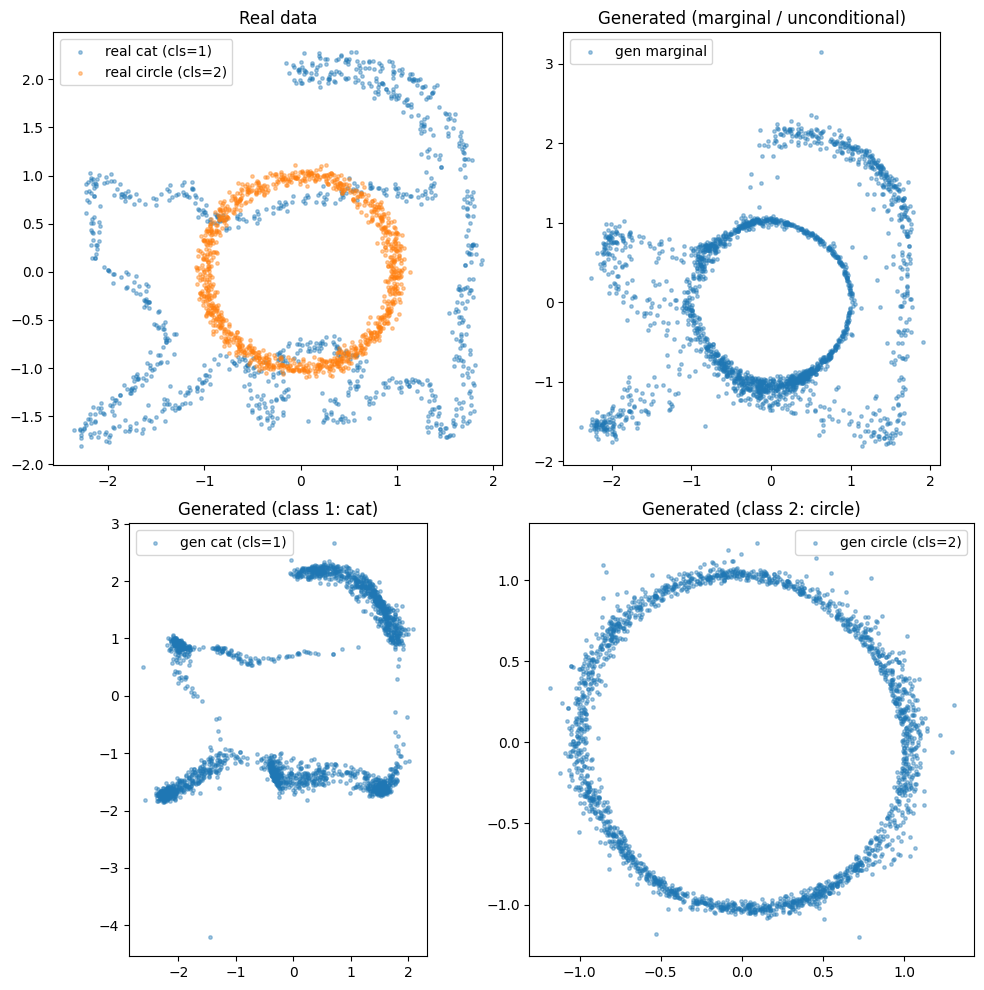

In [17]:
state = demo_train_and_sample()